Library imports - multiprocessing version, with filter

In [1]:
import datetime
from dateutil import parser
import pytz
from timezonefinder import TimezoneFinder

import numpy as np
import scipy.signal as signal
from scipy import interpolate
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt

import time, sys
import re

import xml.etree.ElementTree as ET
import bs4 as bs
import urllib.request
from selenium import webdriver

from multiprocessing import Pool, cpu_count

start_time = time.time()
    
#%matplotlib inline
#https://github.com/MrMinimal64/timezonefinder

utc=pytz.UTC

#debug = True
debug = True
filepath = './sample_data/'

if debug == False:
    gpx_file = input('Enter file name (must be in same directory as this program for now): ')
    tree = ET.parse(filepath + gpx_file)
else:
    #tree = ET.parse('./sample_data/Exciter_100.gpx')
    tree = ET.parse('./sample_data/S4_Form_Sprints_20_min_M1_Tempo.gpx')
    #tree = ET.parse('./sample_data/ITPS_out.gpx')
    #tree = ET.parse('./sample_data/See_you_later_Winter_welcome_Spring.gpx')
root = tree.getroot()

each gps device has its own namespace for recording the GPX file... this function reads the embeded namespace

In [2]:
def namespace(element):
    m = re.match('\{(.*)\}', element.tag)
    return m.group(1) if m else ''

In [3]:
#url = 'http://vortex.plymouth.edu/cgi-bin/sfc/gen-statlog-a.cgi?ident=cyxu&pl=rawspec&yy=19&mm=04&dd=04&pg=web'
#dialog http://vortex.plymouth.edu/myo/sfc/statlog-a.html
#choose raw hourly & special METAR obs listings
#but only valid for us/cn/mx
#options
#http://www.ogimet.com/metars.phtml.en
#http://www.ogimet.com/display_metars2.php?lang=en&lugar=sbsp&tipo=ALL&ord=REV&nil=SI&fmt=html&ano=2019&mes=04&day=04&hora=00&anof=2019&mesf=04&dayf=04&horaf=23&minf=59&send=send

#https://www.cyclinganalytics.com/

In [4]:
#namespace = {'gpx':'http://www.topografix.com/GPX/1/1'}
namespace = {'gpx':namespace(root)}

In [5]:
#helper functions
def deg2rad(x):
    return x * np.pi / 180

def rad2deg(angle):
    return angle * 180 / np.pi

def kt2ms(speed):
    return speed * 0.5144444

def ms2kmh(speed):
    return speed * 3.6

def kmh2kt(speed):
    return speed / 1.852

This function calculates the distance and angle between 2 coordinates

In [6]:
def get_dist_trk(p2, p1):
    #p1 is a list with lat and long in degrees
    #p2 is also a list: lat long
    #returns distance and angle
    #distance in metres
    #reference: https://www.movable-type.co.uk/scripts/latlong.html
    R = 6371e3 #mean radius of Earth in meters
    phi1 = deg2rad(p1[0])
    phi2 = deg2rad(p2[0])
    lambda1 = deg2rad(p1[1])
    lambda2 = deg2rad(p2[1])
    delta_phi = phi2 - phi1
    delta_lambda = lambda2 - lambda1
    a = np.sin(delta_phi / 2) * np.sin(delta_phi / 2) + \
        np.cos(phi1) * np.cos(phi2) * \
        np.sin(delta_lambda / 2) * np.sin(delta_lambda / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    y = np.sin(delta_lambda) * np.cos(phi2)
    x = np.cos(phi1) * np.sin(phi2) - \
        np.sin(phi1) * np.cos(phi2) * np.cos(delta_lambda)
    brg = np.arctan2(y,x) * 180 / np.pi
    return d, brg + 180

Loop through GPX file for each recorded track point and calculate distance and angle

In [7]:
def get_trk_pts_data(trksegmt):
    '''
    function to generate track data
    input: list of tracksegments
    
    output: dataframe containing track data
    '''
    trackpoint = {}
    track = pd.DataFrame(columns=['lat', 'lon', 'elev', 'ts', 'dist', 'true_hdg', 'gs', 'delta_t', 'm_power', 'amb_temp', 'heart_rate', 'cadence'])
    first_point = True
    debug_counter = 0
    for idx, trkpoint in enumerate(trksegmt):
        trackpoint['lat'] = float(trkpoint.get('lat'))
        trackpoint['lon'] = float(trkpoint.get('lon'))
        for elev in trkpoint.findall('gpx:ele', namespace):
            #print(elev.text)
            trackpoint['elev'] = float(elev.text)
        for ts in trkpoint.findall('gpx:time', namespace):
            #print(ts.text)
            trackpoint['ts'] = parser.parse(ts.text)
        
        #garmin extensions
        for extensions in trkpoint.findall('gpx:extensions', namespace):
            #print(extensions)
            for ext in extensions:
                #print(ext.getchildren())
                #print(ext.__class__)
                #print('power is: ', ext.tag, ext.text)
                if 'power' in ext.tag:
                    #print('this is power...', float(ext.text))
                    trackpoint['m_power'] = float(ext.text)
                for child in ext:
                    #print(child.tag)
                    if 'atemp' in child.tag:
                        #print('this is the ambient temp:', float(child.text))
                        trackpoint['amb_temp'] = float(child.text)
                    if 'hr' in child.tag:
                        #print('this is the heart rate:', float(child.text))
                        trackpoint['heart_rate'] = float(child.text)
                    if 'cad' in child.tag:
                        #print('this is the cadence:', float(child.text))
                        trackpoint['cadence'] = float(child.text)
        
        if first_point:
            previous_point = trackpoint
            first_point = False
        dist, angle = get_dist_trk([previous_point['lat'],previous_point['lon']], [trackpoint['lat'],trackpoint['lon']])
        if debug_counter < 20:
            #print(dist, trackpoint['lon'], previous_point['lon'])
            debug_counter += 1

        trackpoint['delta_t'] = (trackpoint['ts']-previous_point['ts']).total_seconds()
        trackpoint['dist'] = dist
        trackpoint['true_hdg'] = angle
        if trackpoint['delta_t'] != 0:
            trackpoint['gs'] = dist / trackpoint['delta_t']
        else:
            trackpoint['gs'] = 0
            trackpoint['delta_t'] = np.nan
            
        previous_point = trackpoint
        track = track.append(trackpoint, ignore_index=True)
        trackpoint = {}
    return track

In [8]:
print('Building track database...')
#track = pd.DataFrame(columns=['lat', 'lon', 'elev', 'ts', 'dist', 'true_hdg', 'gs', 'delta_t'])
#lat in deg decimal
#lon in deg decimal
#elev in meters
#ts in datetime, tz=0
#dist in meters
#true_hdg in degrees
#gs in m/s

debug_counter = 0
n_proc = cpu_count() #number of multiprocesses in pool

for trk in root.findall('gpx:trk', namespace):
    for trksegmt in trk.findall('gpx:trkseg', namespace):
        first_point = True
        trkpoints = trksegmt.findall('gpx:trkpt', namespace)
        trk_pts_number = len(trkpoints)
        trk_pts_set = []
        
        for i in range(n_proc):
            if i < (n_proc - 1):
                trk_pts_set.append(trkpoints[int(trk_pts_number / n_proc) * (i):(int(trk_pts_number / n_proc) * (i+1) -1)])
            else:
                trk_pts_set.append(trkpoints[int(trk_pts_number / n_proc) * (i):trk_pts_number])
            
        #get_trk_pts_data(trk_pts_set[0])
        n_proc
        pool = Pool(n_proc)
        #map guarantees the order back
        results = pool.map(get_trk_pts_data, trk_pts_set)
        pool.join
        #join results:
        track = pd.DataFrame(columns=['lat', 'lon', 'elev', 'ts', 'dist', 'true_hdg', 'gs', 'delta_t', 'm_power', 'amb_temp', 'heart_rate', 'cadence'])
        for result in results:
            track = track.append(result.set_index('ts'))
        track['ts'] = track.index
        track.reset_index(inplace=True, drop=True)       
        pool.terminate
        pool.close()
        
        


end_time = time.time()
print()
print('Track build time was {:1.1f} seconds'.format(end_time - start_time))

Building track database...

Track build time was 66.1 seconds


In [9]:
#Butterworth filter definition
def apply_filter(raw_data, N, Wn):
    
    # N is the filter order
    #Wn is the 3db cutoff kink point
    B, A = signal.butter(N, Wn, output='ba')
    
    filtered_data = signal.filtfilt(B, A, raw_data)
    return filtered_data

In [10]:
#save the originals for filtering later
track['gs_raw'] = track['gs'] 
track['dist_raw'] = track['dist']
track['elev_raw'] = track['elev']

#calc delta elevation between points
#track['delta_elev'] = track['elev'].diff()

In [11]:
#filter comparison
#track['gs'] = track['gs_raw'].rolling(window=20).mean() * 3.6
track['gs'] = apply_filter(track['gs_raw'], 4, 0.04)
#conclusion is that the butterworth is better. Smoother signal and maybe less lag
track['dist'] = apply_filter(track['dist_raw'], 4, 0.04)
track['elev'] = apply_filter(track['elev_raw'], 4, 0.02)
track['delta_elev'] = track['elev'].diff()
#track['delta_elev'] = apply_filter(track['delta_elev'], 4, 0.02)

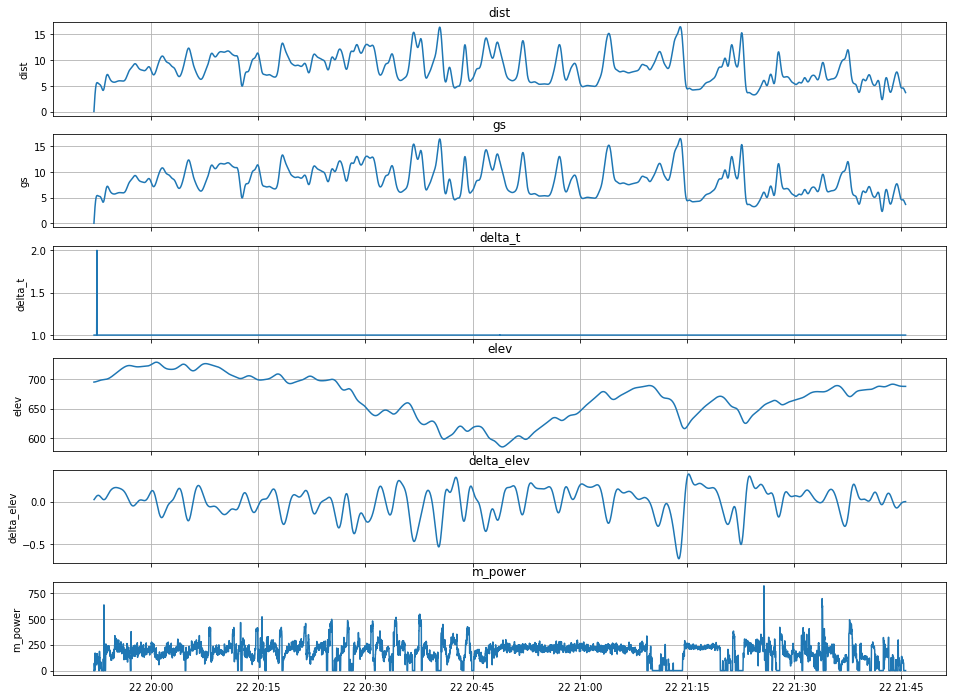

In [12]:
#Quick plot for checking...
plt_list = ['dist', 'gs', 'delta_t', 'elev', 'delta_elev', 'm_power']
#plt_list = ['dist', 'gs', 'delta_t', 'elev']
plt.rcParams['figure.figsize'] = [16, 12]
f, axarr = plt.subplots(len(plt_list), sharex=True)
for idx, pltdata in enumerate(plt_list):
    axarr[idx].plot((track['ts']),track[pltdata])
    axarr[idx].set(ylabel=pltdata,
       title=pltdata)
    axarr[idx].grid()
plt.show()

In [13]:
#pandas
#shift
#apply
#applymap
#run apply on column and use lambda to filter the 2 data points and pass to function

Calculate the mean LAT / LON

Find weather stations near the mean

In [14]:
radial_distance = 100 #nm
print(f'Figuring out nearest weather station...using {radial_distance} nm search radius...')
#nearest airport
#http://aviationweather.gov/adds/dataserver_current/httpparam?dataSource=stations&requestType=retrieve&format=xml&radialDistance=20;-81.275376,43.024538
lon_mean = track['lon'].mean()
lat_mean = track['lat'].mean()
ride_day = track['ts'][0].day
ride_month = track['ts'][0].month
ride_year = track['ts'][0].year



url = 'http://aviationweather.gov/adds/dataserver_current/httpparam?dataSource=stations&requestType=retrieve' + \
      '&format=xml&radialDistance=' + str(radial_distance) + ';' + str(lon_mean) + ',' + str(lat_mean)

source = urllib.request.urlopen(url).read()
tree = ET.ElementTree(ET.fromstring(source))
root = tree.getroot()
station_id_list = []
for data in root.findall('data'):
    for station in data.findall('Station'):
        for station_ident in station.findall('station_id'):
            station_id_list.append(station_ident.text)
print('Nearest stations are: ', station_id_list)

Figuring out nearest weather station...using 100 nm search radius...
Nearest stations are:  ['SBAQ', 'SBBT', 'SBBU', 'SBGP', 'SBLN', 'SBRP', 'SBSA', 'SBSR', 'SBYS']


Cycle each station and try to find a METAR

If found, then create the weather database

If not found, asks user to enter prevailing wind speed and direction (true magnetic)

In [15]:
print(lat_mean)
print(lon_mean)

-21.7144034995596
-48.2553385068996


other sites from this thread:
http://www.redemet.aer.mil.br/api/consulta_automatica/index.php?local=sbgp&msg=metar&data_ini=2020052201&data_fim=2020052223


In [16]:
def get_redemet_data(station, ride_day, ride_month, ride_year):
    '''
    retrieve weather data from REDEMET
    this site only offers BRASIL
    inputs:
        station: (str) - 4 letter code
        ride_day, ride_month, ride_year: (int)
    returns:
        found_data: (bool) true if data was found
        metinfo: (list) - parsed data
        
    site url template:
    https://www.redemet.aer.mil.br/?i=facilidades&p=api-redemet
    http://www.redemet.aer.mil.br/api/consulta_automatica/index.php?local=sbgp&msg=metar&data_ini=2020052201&data_fim=2020052223
    '''

    #only try to retrieve data if station is not null
    metar_found = False
    metar_db = []
    if station != '':
        url = f'http://www.redemet.aer.mil.br/api/consulta_automatica/index.php?local={station}'+ \
        f'&msg=metar&data_ini={ride_year}{ride_month:02d}{ride_day:02d}00'+ \
        f'&data_fim={ride_year}{ride_month:02d}{ride_day:02d}23' #from 00h to 23h on that day
        page = urllib.request.urlopen(url).read()
        soup = bs.BeautifulSoup(page)
        body = soup.body
        lines = body.get_text().splitlines()
        for line in lines:
            #parse list with metars
            #possible lines:
            #"2020052213 - Mensagem METAR de 'SBGP' para 22/05/2020 as 13(UTC) não localizada na base de dados da REDEMET",
            #'2020052214 - METAR SBGP 221400Z 03020KT CAVOK 26/17 Q1019=',
            w_offset = 0 #offset for VRB wind speed
            if 'localizada' in line:
                pass
            else:
                metar_found = True
                line_items = line.split(' ')
                #let's split the items now
                #['2020052214', '-', 'METAR', 'SBGP', '221400Z', '03020KT', 'CAVOK', '26/17', 'Q1019=']
                mdate = line_items[4]
                mwind = line_items[5]
                mday = int(mdate[:2])
                mhour = int(mdate[2:4])
                mminute = int(mdate[4:6])
                if mwind[:2] == 'VR':
                    wind_dir = 0
                    w_offset = 1
                else:
                    wind_dir = int(mwind[:2])
                wind_spd = int(mwind[2+w_offset:5])
                metar_station = line_items[3]
                metar_db.append([datetime.datetime(year=ride_year, month=ride_month, day=ride_day, 
                                                           hour=mhour, minute=mminute, second=0, tzinfo=pytz.UTC), 
                                                           wind_dir, wind_spd])

        weather_data = pd.DataFrame(columns=['Time', 'Wind_Dir', 'Wind Speed'] , data=metar_db)
        weather_data['Time'] = pd.to_datetime(weather_data['Time'])
        weather_data.sort_values(by='Time',ascending=True, inplace=True)
        weather_data.set_index('Time')
        return metar_found, weather_data
    else:
        return False, None

In [17]:
def get_ogi_data(station, ride_day, ride_month, ride_year):
    '''
    retrieve weather data from OGIMET
    this site only offers the last 30 days
    inputs:
        station: (str) - 4 letter code
        ride_day, ride_month, ride_year: (int)
    returns:
        found_data: (bool) true if data was found
        metinfo: (list) - parsed data
        
    site url template:
    http://www.ogimet.com/display_metars2.php?lang=en&amp;lugar=CYXU&amp;tipo=ALL&amp;ord=REV&amp;nil=SI&amp;fmt=html&amp;ano=2020&amp;mes=5&amp;day=16&amp;hora=00&amp;anof=2020&amp;mesf=5&amp;dayf=16&amp;horaf=23&amp;minf=59&amp;send=send
    http://www.ogimet.com/display_metars2.php?lang=en&lugar=CYXU&tipo=ALL&ord=REV&nil=SI&fmt=html&ano=2020&mes=05&day=16&hora=21&anof=2020&mesf=05&dayf=16&horaf=21&minf=59&send=send
    '''

    #only try to retrieve data if station is not null
    metar_found = False
    metar_db = []
    if station != '':
        url = 'http://www.ogimet.com/display_metars2.php?lang=en&lugar='+str(station)+ \
        '&tipo=ALL&ord=REV&nil=SI&fmt=html&ano='+str(ride_year)+ \
        '&mes='+str(ride_month)+'&day='+str(ride_day)+ \
        '&hora=00&anof='+str(ride_year)+'&mesf='+str(ride_month)+'&dayf='+str(ride_day)+ \
        '&horaf=23&minf=59&send=send'
        source = urllib.request.urlopen(url).read()
        soup = bs.BeautifulSoup(source, features='html.parser')
        table = soup.table
        table_rows = table.find_all('tr')
        metar_list = []
        for tr in table_rows:
            td = tr.find_all('td')
            row = [i.text for i in td]
            metar_list.append(row)
        for idx, line in enumerate(metar_list):
            #print(idx, line)
            for item in line:
                found = item.find('METAR '+str(station))
                if found != -1:
                    metar_found = True
                    try:
                        mday = int(item[found+11:found+13])
                        mhour = int(item[found+13:found+15])
                        mminute = int(item[found+15:found+17])
                        wind_dir = int(item[found+19:found+22])
                        wind_spd = int(item[found+22:found+24])
                        metar_station = str(station)
                        #print('mday:', mday)
                        #print('mhour:', mhour)
                        #print('mminute:', mminute)
                        #print('wind_dir:', wind_dir)
                        #print('wind_spd:', wind_spd)

                        metar_db.append([datetime.datetime(year=ride_year, month=ride_month, day=ride_day, 
                                                           hour=mhour, minute=mminute, second=0, tzinfo=pytz.UTC), 
                                                           wind_dir, wind_spd])
                        #wind speed is in knots, default of a METAR

                    except:
                        #print('parsing error')
                        pass
        #naming columns to harmonize with wunder...not my choice
        weather_data = pd.DataFrame(columns=['Time', 'Wind_Dir', 'Wind Speed'] , data=metar_db)
        weather_data['Time'] = pd.to_datetime(weather_data['Time'])
        weather_data.sort_values(by='Time',ascending=True, inplace=True)
        weather_data.set_index('Time')
        return metar_found, weather_data
    else:
        return False, None

In [18]:
def get_wunder_data(station, ride_day, ride_month, ride_year):
    '''
    retrieve weather data from WUNDERGROUND
    inputs:
        station: (str) - 4 letter code
        ride_day, ride_month, ride_year: (int)
    returns:
        found_data: (bool) true if data was found
        metinfo: (pandas.df) - parsed data
        
    site url template:
      https://www.wunderground.com/history/daily/CYXU/date/2004-5-10
    '''
    
    url = 'https://www.wunderground.com/history/daily/'+str(station)+ \
    '/date/' + str(ride_year) + '-' + str(ride_month) + '-'+str(ride_day)

    # instantiate webdriver and get data
    # you need firefox bynary and the geckodriver installed
    # the geckodriver interfaces with firefox to get the page and pass the data back
    wd = webdriver.Firefox()
    wd.get(url)

    soup = bs.BeautifulSoup(wd.page_source, 'lxml')

    wd.quit()
    
    #find all tables
    
    data_found = False
    table_index = 0
    tables = soup.find_all('table')
    
    #find the correct table
    for tidx, table in enumerate(tables):
        table_head = table.findAll('th')
        output_head = []
        for head in table_head:
            output_head.append(head.text.strip())
            if output_head[0] == 'Time':
                data_found = True
                table_index = tidx
    #get the data
    
    if not data_found:
        #if no tables found, return false and an None
        return data_found, None
    else:

        table = tables[table_index]

        # parse table - first the header
        table_head = table.findAll('th')
        output_head = []
        for head in table_head:
            output_head.append(head.text.strip())

        # create empty dataframe
        weather_data = pd.DataFrame(columns=output_head)

        # parse rows
        output_rows = []
        rows = table.findAll('tr')
        for row in rows:
            columns = row.findAll('td')
            clean_row = []
            for column in columns:
                clean_row.append(column.text.strip().replace(u'\xa0', '') #this is to remove unwanted characters
                                 .replace('mph', '') 
                                 .replace('F', '')
                                 .replace('in', ''))
            if len(clean_row) > 0: # discard row if it is empty
                output_rows.append(clean_row)

        # add it all to the dataframe
        weather_data = pd.DataFrame(columns=output_head, data=output_rows).apply(pd.to_numeric, errors='ignore')

        # substitute wind direction for numeric headings
        wind_dir_dict = {"N":0,"NNE":22.5,"NE":45,"ENE":67.5,
                         "E":90,"ESE":112.5, "SE":135, "SSE":157.5,
                         "S":180,"SSW":202.5,"SW":225,"WSW":247.5,
                         "W":270,"WNW":292.5,"NW":315,"NNW":337.5, 
                         "CALM":0, "VAR":0}

        weather_data['Wind_Dir'] = weather_data['Wind'].map(wind_dir_dict)

        #make time something useful
        weather_data['Time'] = pd.to_datetime(weather_data['Time'].apply(lambda x : str(ride_year)+
                                                                         '-'+str(ride_month)+
                                                                         '-'+str(ride_day)+
                                                                         ' '+x))
        #sort
        weather_data.sort_values(by='Time',ascending=True, inplace=True)
        #harmonize and keep wind speed in kts
        weather_data['Wind Speed'] = kmh2kt(weather_data['Wind Speed'])
        print()
        print('returning this weather data:')
        print(weather_data)
        
        return data_found, weather_data

In [20]:
metinfo_found = False
datetime.date.today()
delta_days = (datetime.date.today() - (track['ts'][0].to_pydatetime()).date()).days

station_index = 0
while metinfo_found == False and station_index < len(station_id_list):

    if delta_days < 30:
        #try to get data from ogimet
        #if successful set metinfo_found = True
        print(f"Checking if I can find data for station {station_id_list[station_index]} at OGI...", end='')
        
        if station_id_list[station_index]!= '':
            metinfo_found, metinfo_db = get_ogi_data(station_id_list[station_index], ride_day, ride_month, ride_year)
        if metinfo_found:
            print("found data!")
        else:
            print("no")
            
    if (not metinfo_found) and ('SB' in station_id_list[station_index]):
        print(f"Checking if I can find data for station {station_id_list[station_index]} at REDEMET...", end='')
        
        if station_id_list[station_index]!= '':
            metinfo_found, metinfo_db = get_redemet_data(station_id_list[station_index], ride_day, ride_month, ride_year)
        if metinfo_found:
            print("found data!")
        else:
            print("no")
        
    if not metinfo_found:
        #try to get data from wunder
        #if successful, set metinfo_found = True
        print(f"Checking if I can find data for station {station_id_list[station_index]} at Wunder...", end='')
        
        if station_id_list[station_index]!= '':
            metinfo_found, metinfo_db = get_wunder_data(station_id_list[station_index], ride_day, ride_month, ride_year)
        if metinfo_found:
            #we neeed to shift the time because Wunder returns local time. We need UTC
            tf = TimezoneFinder()
            ride_tz = tf.timezone_at(lng=lon_mean, lat=lat_mean)
            metinfo_db['Time'] = pd.to_datetime(metinfo_db['Time']).dt.tz_localize(ride_tz).dt.tz_convert('UTC')
            
            print("found data!")
        else:
            print("no")
            
    station_index += 1
if not metinfo_found:
    #manual entry
    print('no auto METAR data')
    wind_dir = input('Enter wind direction (true heading): ')
    wind_spd = input('Enter wind speed: ')
    ride_date = datetime.datetime(year=ride_year, month=ride_month, day=ride_day, hour=0, minute=0, second=0, tzinfo=pytz.UTC)
    metinfo_db = pd.DataFrame({'Time':ride_date, 'Wind_Dir':int(wind_dir), 'Wind Speed':float(wind_spd)}, index=[0])
    

Checking if I can find data for station SBAQ at REDEMET...no
Checking if I can find data for station SBAQ at Wunder...no
Checking if I can find data for station SBBT at REDEMET...no
Checking if I can find data for station SBBT at Wunder...
returning this weather data:
                  Time  Temperature  Dew Point Humidity Wind  Wind Speed  \
0  2020-05-22 00:00:00           66         57      73%  SSE    2.699784   
1  2020-05-22 01:00:00           64         57      77%    S    3.239741   
2  2020-05-22 02:00:00           64         57      77%  SSE    2.699784   
3  2020-05-22 03:00:00           64         57      77%  SSE    1.619870   
4  2020-05-22 04:00:00           64         57      77%    S    2.699784   
5  2020-05-22 05:00:00           63         57      82%  SSE    2.699784   
6  2020-05-22 06:00:00           63         57      82%    S    2.699784   
7  2020-05-22 07:00:00           61         57      88%  SSE    2.699784   
8  2020-05-22 08:00:00           66         59 

Calculates the headwind component and stores in database

In [21]:
print(station_id_list, ride_day, ride_month, ride_year)


['SBAQ', 'SBBT', 'SBBU', 'SBGP', 'SBLN', 'SBRP', 'SBSA', 'SBSR', 'SBYS'] 22 5 2020


In [22]:
#metinf_db['Time'] = pd.to_datetime(metinfo_db['Time'])
metinfo_db
#print(track['ts'].iloc[0], track['ts'].iloc[-1] )

,Time,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Precip.,Condition,Wind_Dir
0,2020-05-22 03:00:00+00:00,66,57,73%,SSE,2.699784,0,28.18,0.0,air,157.5
1,2020-05-22 04:00:00+00:00,64,57,77%,S,3.239741,0,28.15,0.0,air,180.0
2,2020-05-22 05:00:00+00:00,64,57,77%,SSE,2.699784,0,28.15,0.0,air,157.5
3,2020-05-22 06:00:00+00:00,64,57,77%,SSE,1.619870,0,28.15,0.0,air,157.5
4,2020-05-22 07:00:00+00:00,64,57,77%,S,2.699784,0,28.15,0.0,air,180.0
5,2020-05-22 08:00:00+00:00,63,57,82%,SSE,2.699784,0,28.15,0.0,air,157.5
6,2020-05-22 09:00:00+00:00,63,57,82%,S,2.699784,0,28.15,0.0,air,180.0
7,2020-05-22 10:00:00+00:00,61,57,88%,SSE,2.699784,0,28.18,0.0,air,157.5
8,2020-05-22 11:00:00+00:00,66,59,78%,S,3.239741,0,28.21,0.0,air,180.0
9,2020-05-22 12:00:00+00:00,72,61,69%,E,2.699784,0,28.21,0.0,air,90.0


In [23]:
xx=0
yy=-1
print(track['ts'].iloc[xx])
print(metinfo_db['Time'].iloc[yy])

2020-05-22 19:52:02+00:00
2020-05-23 02:00:00+00:00


Populate wind components...spline version


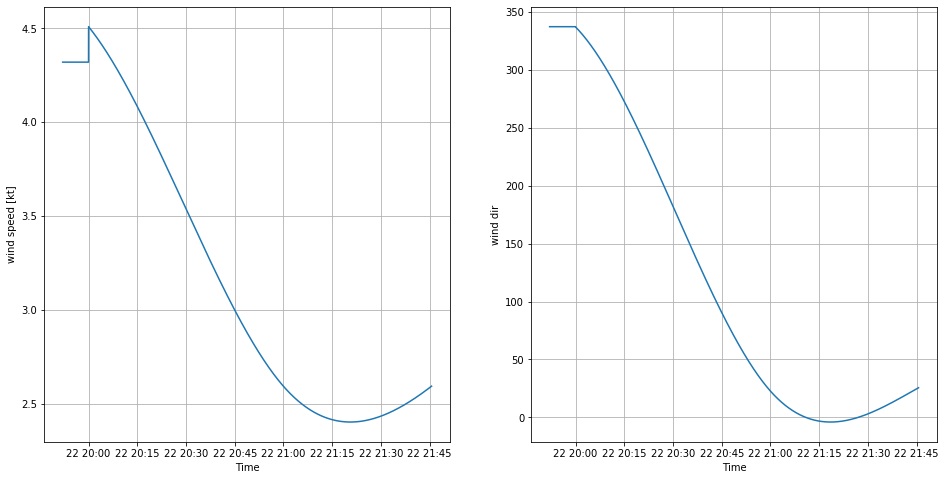

In [24]:
print('Populate wind components...spline version')
#create columns
track['wind_spd'] = 0
track['wind_dir'] = 0

from scipy.interpolate import UnivariateSpline
x = metinfo_db['Time'].values.astype('uint64') / 1e6
y = metinfo_db['Wind Speed']
wss = UnivariateSpline(x, y, s=0.5)

y = metinfo_db['Wind_Dir']
wds = UnivariateSpline(x, y, s=0.5)


#find start
if metinfo_db.shape[0] == 1: #only one wind data point, easy
    track['wind_spd'] = metinfo_db['Wind Speed'][0]
    track['wind_dir'] = metinfo_db['Wind_Dir'][0]
else:
    #find and set values
    '''
    cases that will happen:
    1) last METAR < first track ts
    all track timestamps are > than metar ts
    2) first METAR ts > first track ts
    3) last METAR ts < last track ts
    4) first METAR ts < first track ts (trivial)
    5) last METAR ts > last track ts (trivial)
    '''
    #track earlier than metar
    track.loc[(track['ts'] <= metinfo_db['Time'].iloc[0]), ['wind_spd']] = metinfo_db['Wind Speed'].iloc[0]
    track.loc[(track['ts'] <= metinfo_db['Time'].iloc[0]), ['wind_dir']] = metinfo_db['Wind_Dir'].iloc[0]
    #track later than metar
    track.loc[(track['ts'] >= metinfo_db['Time'].iloc[-1]), ['wind_spd']] = metinfo_db['Wind Speed'].iloc[-1]
    track.loc[(track['ts'] >= metinfo_db['Time'].iloc[-1]), ['wind_dir']] = metinfo_db['Wind_Dir'].iloc[-1]
    
    #track in between
    index_start = metinfo_db[track['ts'].iloc[0] <= metinfo_db['Time']].index[0]
    index_end = metinfo_db[track['ts'].iloc[-1] < metinfo_db['Time']].index[0]
    
    metinfo_indexes = range(index_start, index_end + 1)
    for metinfo_index in metinfo_indexes:
        if metinfo_index == index_start:
            track.loc[track['ts'] <= metinfo_db['Time'].iloc[metinfo_index], ['wind_spd']] = metinfo_db['Wind Speed'].iloc[metinfo_index]
            track.loc[track['ts'] <= metinfo_db['Time'].iloc[metinfo_index], ['wind_dir']] = metinfo_db['Wind_Dir'].iloc[metinfo_index]
            
        else:
            track.loc[(track['ts'] <= metinfo_db['Time'].iloc[metinfo_index]) & \
                       (track['ts'] > metinfo_db['Time'].iloc[metinfo_index - 1]), ['wind_spd']] = \
                       wss(track.loc[(track['ts'] <= metinfo_db['Time'].iloc[metinfo_index]) & \
                       (track['ts'] > metinfo_db['Time'].iloc[metinfo_index - 1]), ['ts']].iloc[:,0].values.astype('uint64') / 1e6)
            track.loc[(track['ts'] <= metinfo_db['Time'].iloc[metinfo_index]) & \
                       (track['ts'] > metinfo_db['Time'].iloc[metinfo_index - 1]), ['wind_dir']] = \
                       wds(track.loc[(track['ts'] <= metinfo_db['Time'].iloc[metinfo_index]) & \
                       (track['ts'] > metinfo_db['Time'].iloc[metinfo_index - 1]), ['ts']].iloc[:,0].values.astype('uint64') / 1e6)

        #else:
        #    track.loc[track['ts'] > metinfo_db['Time'].iloc[metinfo_index], ['wind_spd']] = metinfo_db['Wind Speed'].iloc[metinfo_index]
        #    track.loc[track['ts'] > metinfo_db['Time'].iloc[metinfo_index], ['wind_dir']] = metinfo_db['Wind_Dir'].iloc[metinfo_index]


plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots(1,2)
ax[0].plot((track['ts']), track['wind_spd'])

ax[0].set(xlabel='Time', ylabel='wind speed [kt]')
ax[0].grid()

ax[1].plot((track['ts']), track['wind_dir'])

ax[1].set(xlabel='Time', ylabel='wind dir')
ax[1].grid()

#fig.savefig("test.png")
plt.show()

In [25]:
'''
print('Populate wind components...')
#create columns
track['wind_spd'] = 0
track['wind_dir'] = 0

#find start
if metinfo_db.shape[0] == 1:
    index_start = metinfo_db.index[0]
    index_end = metinfo_db.index[0]
else:
    index_start = metinfo_db[track['ts'].iloc[0] <= metinfo_db['Time']].index[0]
    index_end = metinfo_db[track['ts'].iloc[-1] < metinfo_db['Time']].index[0]

#find and set values

cases that will happen:
1) last METAR < first track ts
all track timestamps are > than metar ts
2) first METAR ts > first track ts
3) last METAR ts < last track ts
4) first METAR ts < first track ts (trivial)
5) last METAR ts > last track ts (trivial)


metinfo_indexes = range(index_start, index_end)
for metinfo_index in range(index_start, index_end+1):
    if metinfo_index == index_start:
        track.loc[track['ts'] <= metinfo_db['Time'].iloc[metinfo_index], ['wind_spd']] = metinfo_db['Wind Speed'].iloc[metinfo_index]
        track.loc[track['ts'] <= metinfo_db['Time'].iloc[metinfo_index], ['wind_dir']] = metinfo_db['Wind_Dir'].iloc[metinfo_index]

    elif metinfo_index < index_end:
        track.loc[(track['ts'] <= metinfo_db['Time'].iloc[metinfo_index]) & \
                   (track['ts'] > metinfo_db['Time'].iloc[metinfo_index - 1]), ['wind_spd']] = metinfo_db['Wind Speed'].iloc[metinfo_index]
        track.loc[(track['ts'] <= metinfo_db['Time'].iloc[metinfo_index]) & \
                   (track['ts'] > metinfo_db['Time'].iloc[metinfo_index - 1]), ['wind_dir']] = metinfo_db['Wind_Dir'].iloc[metinfo_index]

    else:
        track.loc[track['ts'] > metinfo_db['Time'].iloc[metinfo_index], ['wind_spd']] = metinfo_db['Wind Speed'].iloc[metinfo_index]
        track.loc[track['ts'] > metinfo_db['Time'].iloc[metinfo_index], ['wind_dir']] = metinfo_db['Wind_Dir'].iloc[metinfo_index]

plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots(1,2)
ax[0].plot((track['ts']), track['wind_spd'])

ax[0].set(xlabel='Time', ylabel='wind speed [kt]')
ax[0].grid()

ax[1].plot((track['ts']), track['wind_dir'])

ax[1].set(xlabel='Time', ylabel='wind dir')
ax[1].grid()

#fig.savefig("test.png")
plt.show()
'''

'\nprint(\'Populate wind components...\')\n#create columns\ntrack[\'wind_spd\'] = 0\ntrack[\'wind_dir\'] = 0\n\n#find start\nif metinfo_db.shape[0] == 1:\n    index_start = metinfo_db.index[0]\n    index_end = metinfo_db.index[0]\nelse:\n    index_start = metinfo_db[track[\'ts\'].iloc[0] <= metinfo_db[\'Time\']].index[0]\n    index_end = metinfo_db[track[\'ts\'].iloc[-1] < metinfo_db[\'Time\']].index[0]\n\n#find and set values\n\ncases that will happen:\n1) last METAR < first track ts\nall track timestamps are > than metar ts\n2) first METAR ts > first track ts\n3) last METAR ts < last track ts\n4) first METAR ts < first track ts (trivial)\n5) last METAR ts > last track ts (trivial)\n\n\nmetinfo_indexes = range(index_start, index_end)\nfor metinfo_index in range(index_start, index_end+1):\n    if metinfo_index == index_start:\n        track.loc[track[\'ts\'] <= metinfo_db[\'Time\'].iloc[metinfo_index], [\'wind_spd\']] = metinfo_db[\'Wind Speed\'].iloc[metinfo_index]\n        track.loc[

In [26]:
print('Calculating head winds...')

#delta_ang in degrees
#wind_component in m/s
track['delta_ang'] = track['true_hdg'] - track['wind_dir']
track['headwind_comp'] = np.cos(deg2rad(track['delta_ang'])) * kt2ms(track['wind_spd'])
track['airspeed'] = track['gs'] + track['headwind_comp'] #this in ms


Calculating head winds...


Calculates DRAG the power

Todo: interface for Cd and Area; Vary rho per altitude

In [33]:
a = pd.cut(track['airspeed'], 10)

In [35]:
from scipy import interpolate

In [54]:
def crouch_cd(x, crouch_cd_interp, crouch_start, crouch_full):
    if x <= crouch_start:
        return 1
    elif x <= crouch_full:
        return crouch_cd_interp(x)
    else:
        return crouch_cd_interp(crouch_full)
    
def crouch_S(x, crouch_S_interp, crouch_start, crouch_full):
    if x <= crouch_start:
        return 1
    elif x <= crouch_full:
        return crouch_S_interp(x)
    else:
        return crouch_S_interp(crouch_full)

In [110]:
print('Calculating aero power...')
rho = 1.225 #fixed for now kg/m3
Cd = 0.9 #fixed for me
S = 0.516 #measure from photo m2

#Basile
Cd = 0.8 
S = 0.48 

#track['filt_airspeed'] = apply_filter(track['airspeed'], 2, 0.08)
#13% for CD; 10% for area
spd_avrg = track['airspeed'].mean()
spd_std = track['airspeed'].std()
crouch_start = spd_avrg
crouch_full = spd_avrg + 1 * spd_std #experienced bikers will crouch sooner, at 1 std
crouch_full_Cd_mult = 0.87
crouch_full_S_mult = 0.9
crouch_cd_interp = interpolate.interp1d([crouch_start, crouch_full], [Cd, Cd * crouch_full_Cd_mult])
crouch_S_interp = interpolate.interp1d([crouch_start, crouch_full], [Cd, Cd * crouch_full_S_mult])

Calculating aero power...


In [111]:
crouch_S(1, crouch_S_interp, crouch_start, crouch_full)

1

In [112]:
crouch_start

8.853075114521662

In [113]:
track['Cd'] = track.apply(lambda x: Cd * crouch_cd(x['airspeed'], crouch_cd_interp, crouch_start, crouch_full), axis=1)
track['S'] = track.apply(lambda x: S * crouch_S(x['airspeed'], crouch_S_interp, crouch_start, crouch_full), axis=1)



In [114]:
track['S'].iloc[1000]

0.3456

In [115]:
track['drag'] = 0.5 * rho * track['airspeed']**2 * track['Cd'] * track['S']
track['drag_work'] = track['drag'] * track['dist'] #J
track['drag_no_wind'] = 0.5 * rho * track['gs']**2 * Cd * S
track['drag_work_no_wind'] = track['drag_no_wind'] * track['dist'] #J

Calculates the potential energy work

Todo: interface for cyclist and bike mass

In [116]:
cyclist_mass = 85 #kg
bike_mass = 12 #kg

Crr_tire = 0.003
#http://www.biketechreview.com/tires_old/images/AFM_tire_testing_rev9.pdf
#https://www.bicyclerollingresistance.com/

Crr_tire_std = 1 * Crr_tire #average increase due to road not being 100% smooth

mass = cyclist_mass + bike_mass #kg

#rolling resistance model
g = 9.8 #m/s2
Fn = mass * g #normal force
Frr_1_tire = Crr_tire_std * Fn
Frr = Frr_1_tire * 2
track['rr_work'] = Frr * track['dist']
track['rr_power'] = Frr * track['gs']


#track['filt_delta_elev'] = apply_filter(track['delta_elev'], 2, 0.04)
track['pot_work'] = mass * g * track['delta_elev'] #J
track['total_work'] = track['drag_work'] + track['pot_work'] + track['rr_work']#J
track['total_work_no_wind'] = track['drag_work_no_wind'] + track['pot_work'] + track['rr_work']#J
track.drop(track['delta_t'].loc[track['delta_t'] == 0].index, inplace=True) #remove delta_t == 0
track['power'] = track['total_work'] / (track['delta_t'].values)
track['power_no_wind'] = track['total_work_no_wind'] / (track['delta_t'].values)
track.fillna(value=0, inplace=True)

ValueError: fill value must be in categories

In [117]:
print(track.describe())

               lat          lon         elev         dist     true_hdg  \
count  6810.000000  6810.000000  6810.000000  6810.000000  6810.000000   
mean    -21.714401   -48.255338   668.628706     8.340050   201.467070   
std       0.049846     0.053362    37.083465     2.740693   101.857998   
min     -21.790934   -48.339111   584.495262     0.430233     0.560426   
25%     -21.754092   -48.305568   640.820085     6.151064   130.983190   
50%     -21.720625   -48.247021   672.562211     8.051828   181.867912   
75%     -21.670078   -48.205785   699.004015    10.330830   306.688787   
max     -21.622649   -48.181294   729.481506    16.468032   360.000000   

                gs      delta_t      m_power     amb_temp   heart_rate  ...  \
count  6810.000000  6810.000000  6810.000000  6810.000000  6810.000000  ...   
mean      8.339243     1.000147   176.047577    22.430543   147.781204  ...   
std       2.741686     0.012118    95.578758     0.835197    13.855209  ...   
min       0.41752

Calculate averages and basic comparisons...

In [118]:
total_work = track['total_work'].sum()
pos_power_filter = track['total_work'] >= 0
print(f'Total work was {total_work:1.0f} Joules = {total_work * 0.000239006:1.0f} kcal')
workout_time = track['ts'].iloc[-1]-track['ts'].iloc[0]
print('Workout time was {}, or {:1.0f} seconds'.format(workout_time, workout_time.total_seconds()))
print('Average overall power was {:1.0f} Watts'.format(total_work / workout_time.total_seconds()))
print('Average positive power was {:1.0f} Watts'.format(track[track['total_work'] >= 0]['total_work'].sum() / workout_time.total_seconds()))
print('Measured average power was {:1.0f} Watts'.format(track['m_power'].mean()))

Total work was 1174678 Joules = 281 kcal
Workout time was 0 days 01:53:32, or 6812 seconds
Average overall power was 172 Watts
Average positive power was 175 Watts
Measured average power was 176 Watts


In [119]:
a = pd.cut(track['airspeed'], 10)
a.iloc[0]

Interval(1.293, 2.885, closed='right')

In [120]:
end_time = time.time()
print('execution time was {:0.1f} seconds'.format(end_time - start_time))

execution time was 3434.4 seconds


In [121]:
#Need tp filter power...

track['filt_power'] = apply_filter(track['power'], 4, 0.04)
track['filt_power_no_wind'] = apply_filter(track['power_no_wind'], 4, 0.04)
'''
#quick check
plot_list = ['delta_elev', 'drag_work', 'pot_work', 'total_work', 'delta_t', 'power', 'filt_power']
plot_len = len(plot_list)
plt.rcParams['figure.figsize'] = [16, 12]
f, axarr = plt.subplots(plot_len, sharex=True)
for plt_idx, plot_label in enumerate(plot_list):
    axarr[plt_idx].plot(track['ts'], track[plot_label])
    axarr[plt_idx].set(ylabel=plot_label,
                      title=plot_label)
    axarr[plt_idx].grid()
#fig.savefig("test.png")
plt.show()
'''

'\n#quick check\nplot_list = [\'delta_elev\', \'drag_work\', \'pot_work\', \'total_work\', \'delta_t\', \'power\', \'filt_power\']\nplot_len = len(plot_list)\nplt.rcParams[\'figure.figsize\'] = [16, 12]\nf, axarr = plt.subplots(plot_len, sharex=True)\nfor plt_idx, plot_label in enumerate(plot_list):\n    axarr[plt_idx].plot(track[\'ts\'], track[plot_label])\n    axarr[plt_idx].set(ylabel=plot_label,\n                      title=plot_label)\n    axarr[plt_idx].grid()\n#fig.savefig("test.png")\nplt.show()\n'

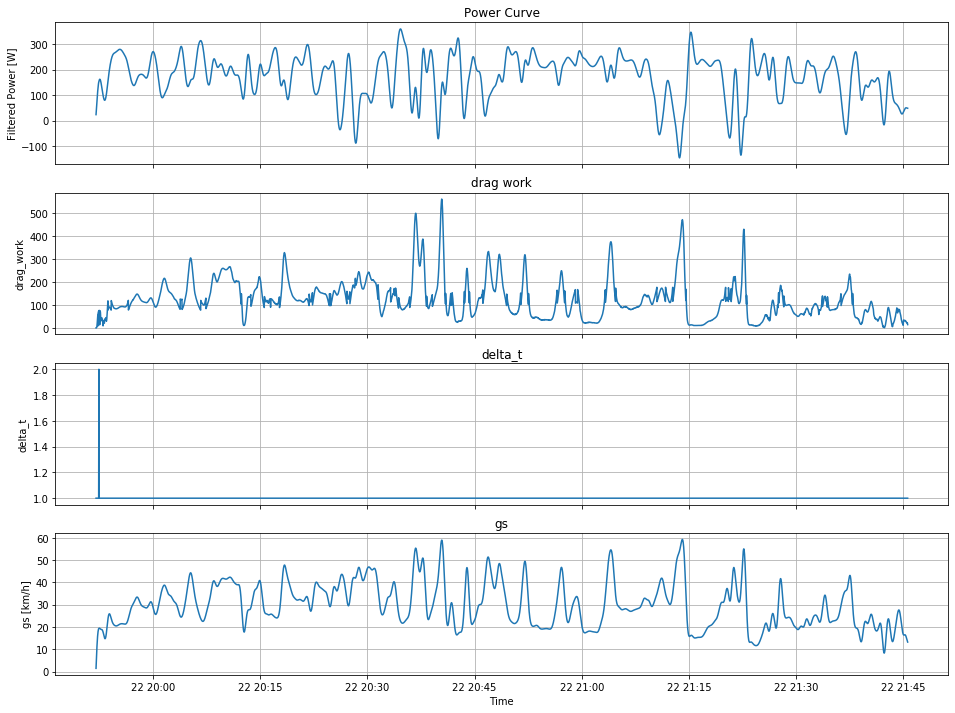

In [122]:
plt.rcParams['figure.figsize'] = [16, 12]
f, axarr = plt.subplots(4, sharex=True)
axarr[0].plot((track['ts']),track['filt_power'])

axarr[0].set(ylabel='Filtered Power [W]',
       title='Power Curve')
axarr[0].grid()

axarr[1].plot((track['ts']),track['drag_work'])

axarr[1].set(ylabel='drag_work',
       title='drag work')
axarr[1].grid()

axarr[2].plot((track['ts']),track['delta_t'].values)

axarr[2].set(ylabel='delta_t',
       title='delta_t')
axarr[2].grid()

axarr[3].plot((track['ts']),(track['gs'])*3.6)

axarr[3].set(xlabel='Time', ylabel='gs [km/h]',
       title='gs')
axarr[3].grid()
             

#fig.savefig("test.png")
plt.show()


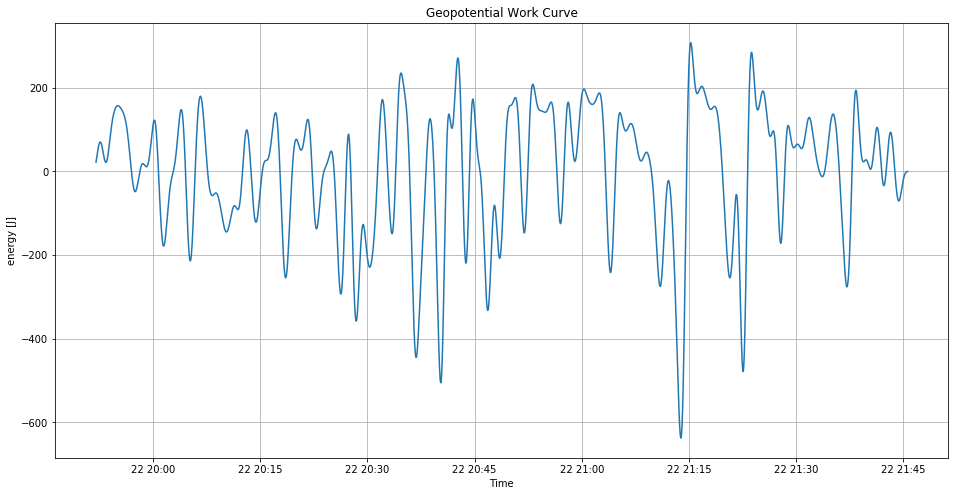

In [123]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()
ax.plot((track['ts']),track['pot_work'])

ax.set(xlabel='Time', ylabel='energy [J]',
       title='Geopotential Work Curve')
ax.grid()

#fig.savefig("test.png")
plt.show()

In [ ]:
'''
f, axarr = plt.subplots(4, sharex=True)
axarr[0].plot((track['ts']),track['power'], alpha=0.8, linewidth=0.3)

axarr[0].set(xlabel='Time', ylabel='Power [W]',
       title='Power Curve')
axarr[0].set_ylim([0, track['power'].max()])
axarr[0].grid()

axarr[1].plot((track['ts']),track['elev'])

axarr[1].set(xlabel='Time', ylabel='Elevation [m]',
       title='Elevation Curve')
axarr[1].grid()

axarr[2].plot((track['ts']),track['delta_ang'])

axarr[2].set(xlabel='Time', ylabel='delta [deg]',
       title='Wind Relative Angle Curve')
axarr[2].grid()

axarr[3].plot((track['ts']),track['delta_elev'])

axarr[3].set(xlabel='Time', ylabel='[m]',
       title='Delta Elev')
axarr[3].grid()
             

#fig.savefig("test.png")
plt.show()
'''

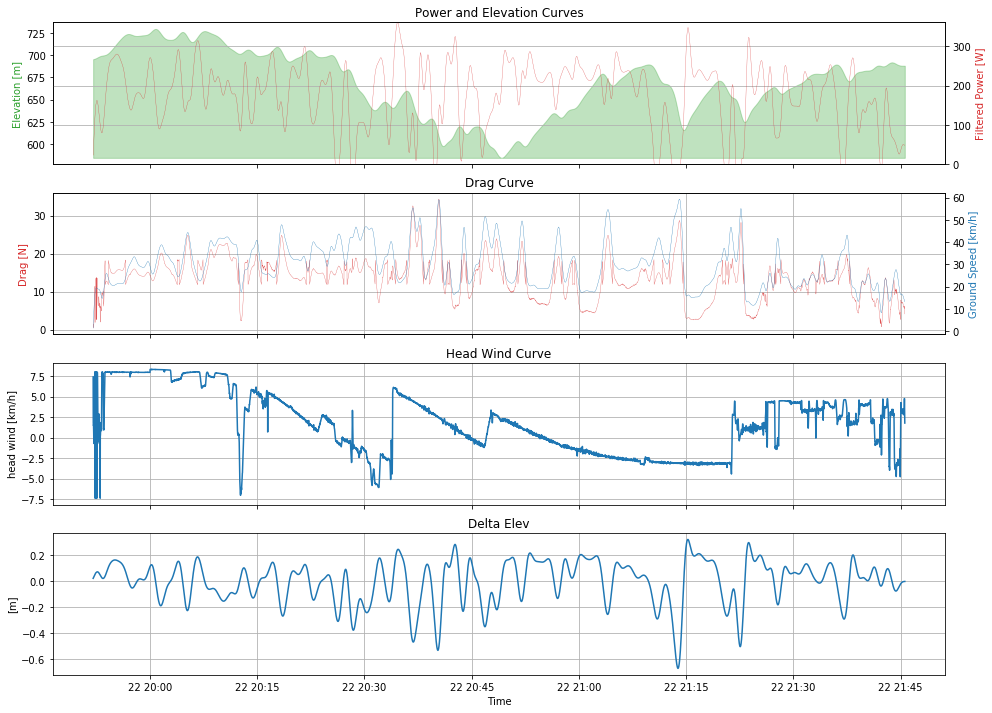

In [124]:
plt.rcParams['figure.figsize'] = [16, 12]
f, axarr = plt.subplots(4, sharex=True)

color = 'tab:green'
axarr[0].fill_between((track['ts']),track['elev'].min(),track['elev'], color=color, alpha=0.3)
axarr[0].set_ylabel('Elevation [m]', color=color)
#fill_between(x, 0, y1)

color = 'tab:red'
ax2 = axarr[0].twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot((track['ts']),track['filt_power'], alpha=0.8, linewidth=0.3, color=color)

ax2.set(xlabel='Time', title='Power and Elevation Curves')
ax2.set_ylabel('Filtered Power [W]', color=color)
ax2.set_ylim([0, track['filt_power'].max()])
ax2.grid()

color = 'tab:red'
axarr[1].plot((track['ts']),track['drag'], alpha=0.8, linewidth=0.3, color=color)


axarr[1].set(title='Drag Curve')
axarr[1].set_ylabel(ylabel='Drag [N]', color=color)
axarr[1].grid()

color = 'tab:blue'
gs_kmh = ms2kmh(track['gs'])
ax3 = axarr[1].twinx()  # instantiate a second axes that shares the same x-axis
ax3.plot((track['ts']), gs_kmh, color=color, linewidth=0.3)
ax3.set_ylabel('Ground Speed [km/h]', color=color)

axarr[2].plot((track['ts']),ms2kmh(track['headwind_comp']))

axarr[2].set(ylabel='head wind [km/h]',
       title='Head Wind Curve')
axarr[2].grid()

axarr[3].plot((track['ts']),track['delta_elev'])

axarr[3].set(xlabel='Time', ylabel='[m]',
       title='Delta Elev')
axarr[3].grid()
             

#fig.savefig("test.png")
plt.show()

Power Histogram

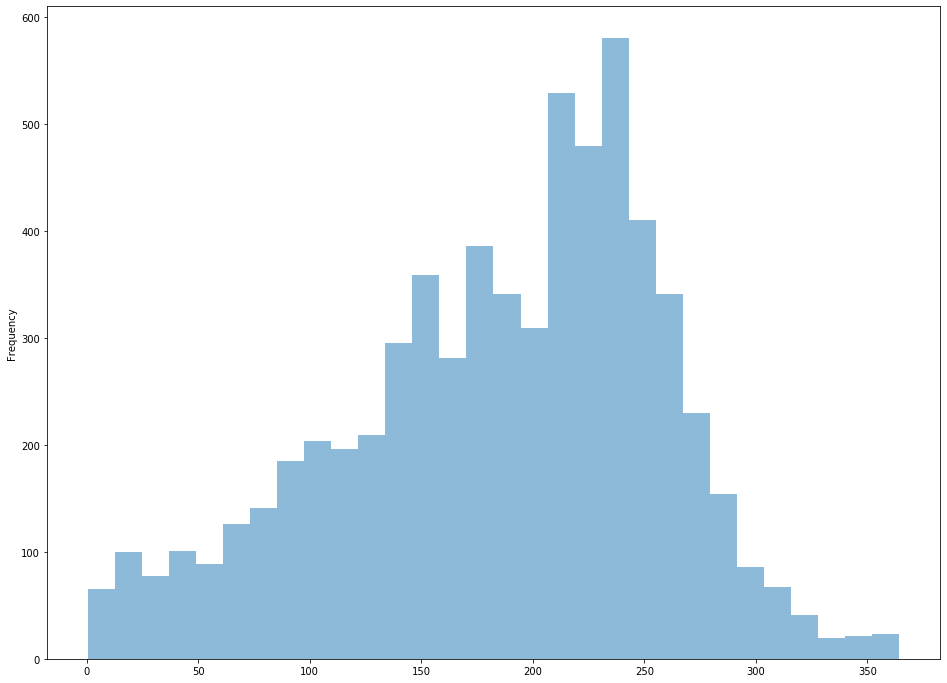

In [125]:
track[track['total_work'] >= 0]
ax = track[track['power']>=0]['power'].plot.hist(bins=30, alpha=0.5)

Power Bins/Time

Let's plot now how many minutes was spent in each power bin.

Change the power range and bin size below.

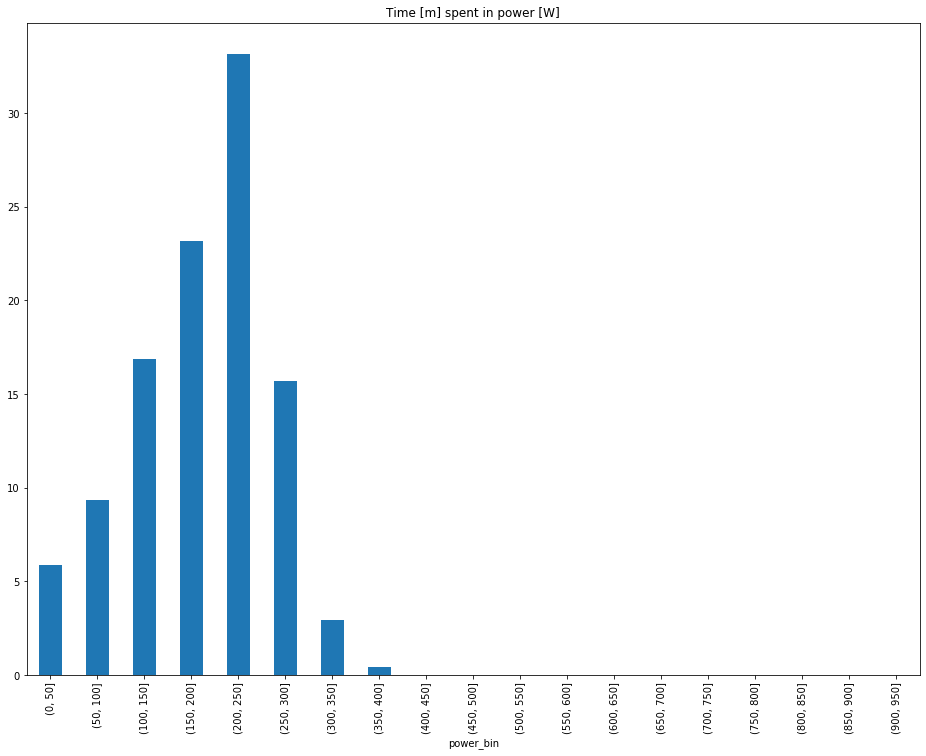

In [126]:
min_power = 0
max_power = 1000
power_bin_width = 50


power_bins =  range(min_power, max_power, power_bin_width)
track['power_bin'] = pd.cut(track['power'], power_bins)
((track.groupby(['power_bin']).sum().loc[:,'delta_t'])/60).plot(kind='bar', title='Time [m] spent in power [W]');

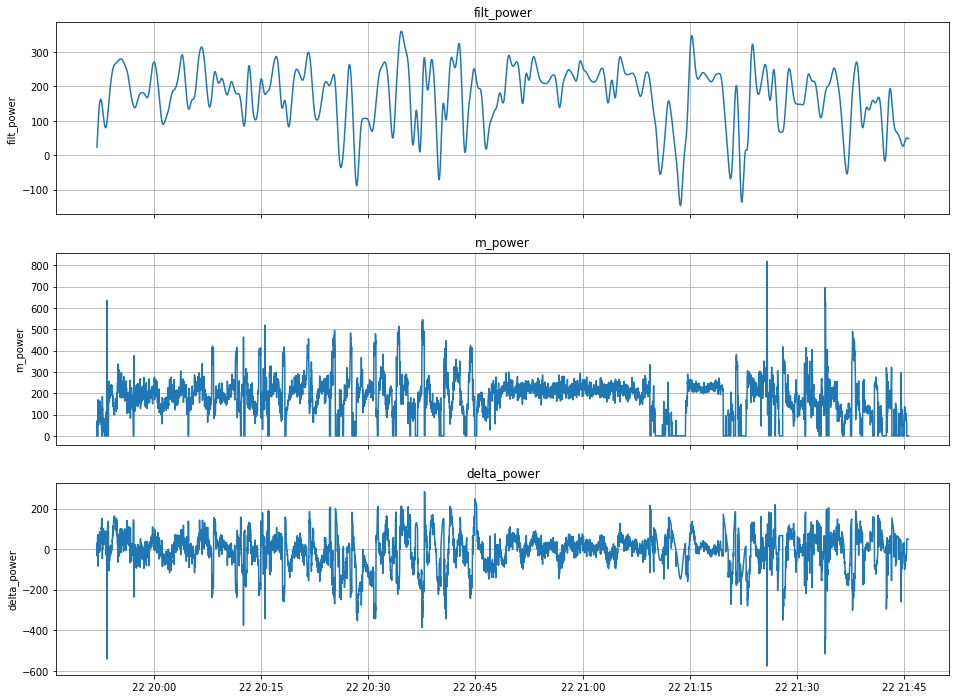

In [127]:
#do a comparison of power with wind and without
track['delta_wind_power'] = track['filt_power'] - track['filt_power_no_wind']
track['delta_power'] = track['filt_power'] - track['m_power']
#plot_list = ['drag_work', 'drag_work_no_wind', 'pot_work', 'total_work', 'total_work_no_wind', 'filt_power', 'filt_power_no_wind', 'delta_wind_power']
plot_list = ['filt_power', 'm_power', 'delta_power']
plot_len = len(plot_list)
plt.rcParams['figure.figsize'] = [16, 12]
f, axarr = plt.subplots(plot_len, sharex=True)
for plt_idx, plot_label in enumerate(plot_list):
    axarr[plt_idx].plot(track['ts'], track[plot_label])
    axarr[plt_idx].set(ylabel=plot_label,
                      title=plot_label)
    axarr[plt_idx].grid()
#fig.savefig("test.png")
plt.show()